# INFO 3402 – Week 10: Forecasting

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)  

## Setup

In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
idx = pd.IndexSlice
pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sb

## Background

Last week covered the fundamentals of working with temporal data in pandas using stock market and Wikipedia data. This lecture is going to focus on finding common patterns in temporal data as well as the implications these patterns have for forecasting and prediction, which we will discuss more next week.

* Finding signal in noisy temporal data
* Common types of temporal patterns found in data (natural and human)
* Simple time series forecasting

## Finding signal in noisy temporal data

### Load Berkeley Earth Surface Temperature estimates

Load the "avg_temp_1880_2021.csv" files with the [Berkeley Earth Surface Temperature](http://berkeleyearth.org/data/) data for the Daily Land estimates from 1880 to the present.

In [2]:
temp_df = pd.read_csv('avg_temp_1880_2021.csv',parse_dates=['Date'])
temp_df.set_index('Date',inplace=True)

temp_df.head()

,AvgTemp
Date,
1880-01-01,8.056
1880-01-02,9.431
1880-01-03,8.956
1880-01-04,9.870
1880-01-05,9.213


Visualize.

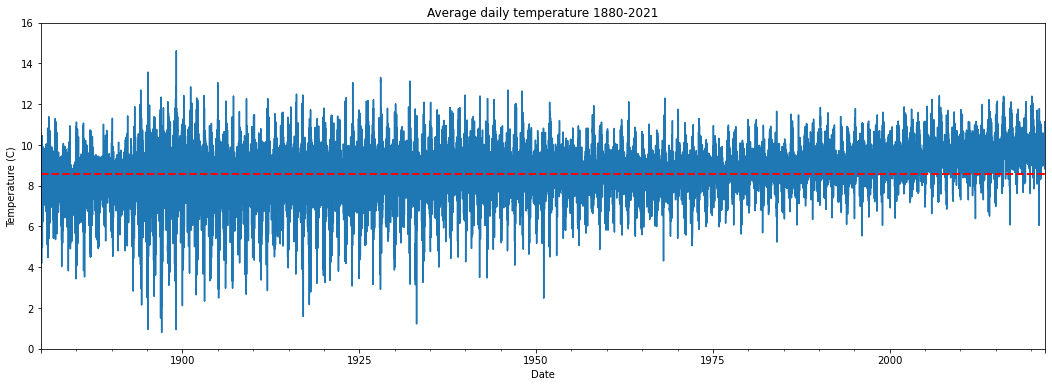

In [5]:
f,ax = plt.subplots(figsize=(18,6))

temp_df['AvgTemp'].plot(ax = ax)
ax.set_ylim((0,16))
ax.set_ylabel('Temperature (C)')
ax.set_title('Average daily temperature 1880-2021')
ax.axhline(8.59,c='r',ls='--',lw=2)

Is there a trend there? Hard to say with such high-resolution and long-term data.

### Re-sampling
Try re-sampling to July 1 each year. The temperture on a single day is not a reliable indicator of a warming pattern.

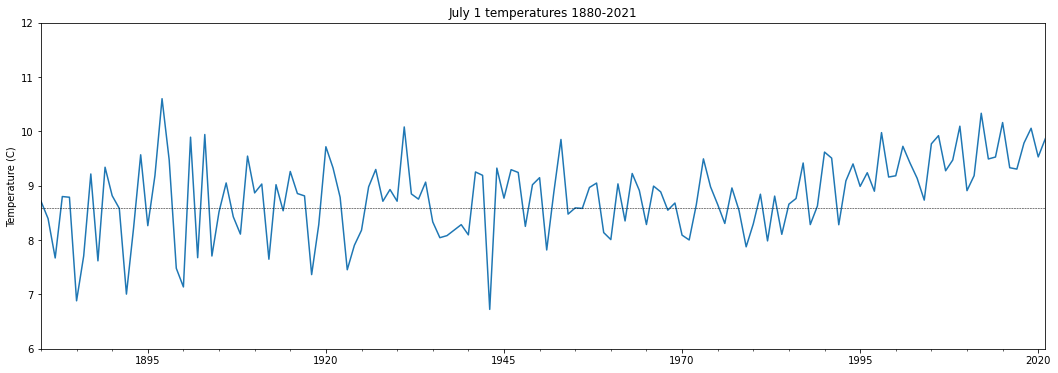

In [6]:
# Make a range of July 1 start dates
july_firsts = pd.date_range(
    start = '1880-07-01',
    end = '2021-07-01',
    freq=pd.DateOffset(years=1)
)

# Re-index
july_first_temps = temp_df.loc[july_firsts]

# Visualize
f,ax = plt.subplots(figsize=(18,6))
july_first_temps['AvgTemp'].plot(ax = ax)
ax.set_ylim((6,12))
ax.set_ylabel('Temperature (C)')
ax.set_title('July 1 temperatures 1880-2021')
ax.axhline(8.59,c='k',ls='--',lw=.5)

### Averaging
If we average the temperatures for each month together that may be a more reliable indicator of the temperature.

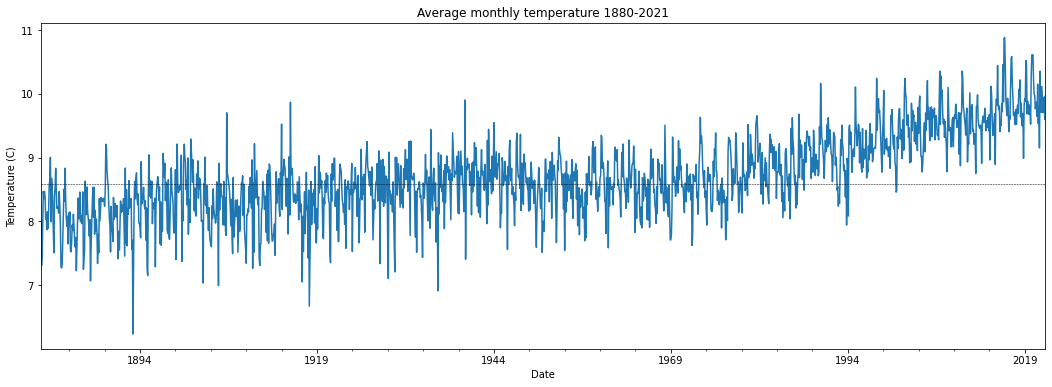

In [7]:
monthly_avg_temps = temp_df.groupby(pd.Grouper(freq='M')).agg({'AvgTemp':'mean'})

f,ax = plt.subplots(figsize=(18,6))
monthly_avg_temps['AvgTemp'].plot(ax = ax)
ax.set_ylabel('Temperature (C)')
ax.set_title('Average monthly temperature 1880-2021')
ax.axhline(8.59,c='k',ls='--',lw=.5)

Try again for annual average temperatures.

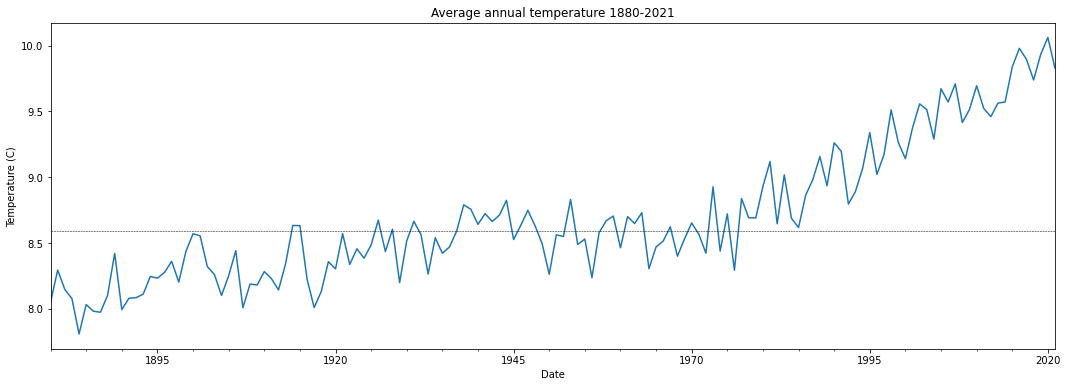

In [8]:
annual_avg_temps = temp_df.groupby(pd.Grouper(freq='Y')).agg({'AvgTemp':'mean'})

f,ax = plt.subplots(figsize=(18,6))
annual_avg_temps['AvgTemp'].plot(ax = ax)
ax.set_ylabel('Temperature (C)')
ax.set_title('Average annual temperature 1880-2021')
ax.axhline(8.59,c='k',ls='--',lw=.5)

### Rolling
We could also make a rolling average of temperatures.

In [9]:
quarterly_rollmean = temp_df['AvgTemp'].rolling(90).mean()
annual_rollmean = temp_df['AvgTemp'].rolling(365).mean()
decadal_rollmean = temp_df['AvgTemp'].rolling(3650).mean()

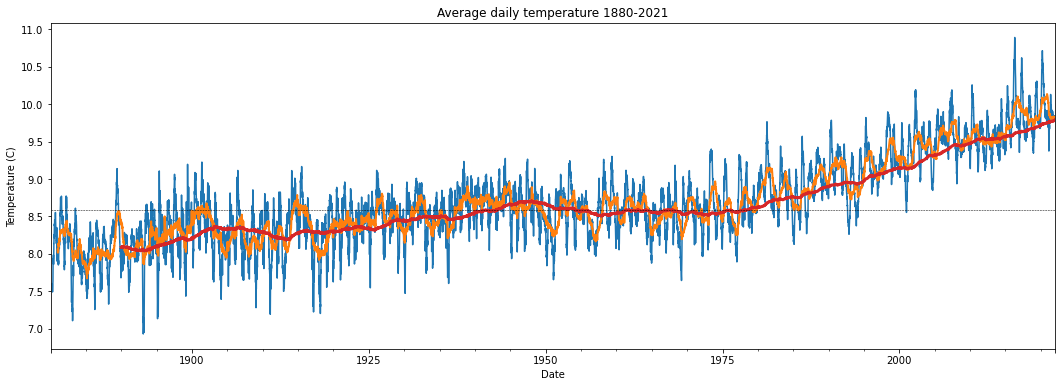

In [14]:
f,ax = plt.subplots(figsize=(18,6))

quarterly_rollmean.plot(ax = ax,color='tab:blue')
annual_rollmean.plot(ax = ax,color='tab:orange',lw=2)
decadal_rollmean.plot(ax = ax,color='tab:red',lw=3)

ax.set_ylabel('Temperature (C)')
ax.set_title('Average daily temperature 1880-2021')
ax.axhline(8.59,c='k',ls='--',lw=.5)

### Box plots

We can make a histogram of all the temperatures in a year, in this case, 1984. They are approximately normally distributed with a temperature just below 9 degrees C.

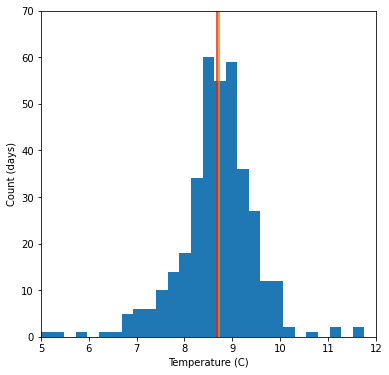

In [15]:
temps_1984 = temp_df.loc['1984','AvgTemp']

f,ax = plt.subplots(figsize=(6,6))

temps_1984.hist(bins=np.linspace(5,12,30),ax=ax,grid=False)
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Count (days)')
ax.set_xlim((5,12))
ax.set_ylim((0,70))

# Average in red
ax.axvline(temps_1984.mean(),color='tab:red')

# Median in orange
ax.axvline(temps_1984.median(),color='tab:orange')

We can also represent the distribution of temperatures as a box plot.

(5.0, 12.0)

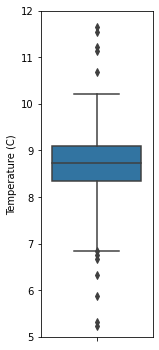

In [16]:
f,ax = plt.subplots(figsize=(2,6))

sb.boxplot(y=temps_1984,ax=ax,color='tab:blue',whis=2)
ax.set_ylabel('Temperature (C)')
ax.set_ylim((5,12))

Now we can use `catplot` to make a box plots for each year's temperature. I "zoomed" into the data since 1984 to make it easier to see.

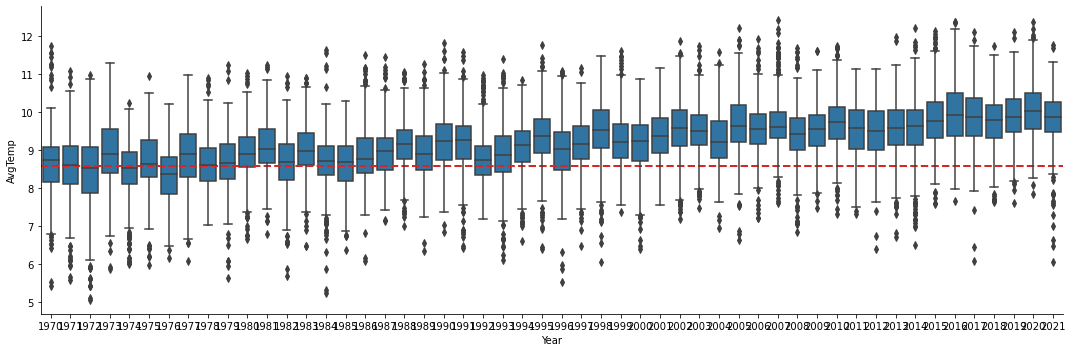

In [23]:
# Add a new column with the year 
temp_df['Year'] = temp_df.index.year

# Filter to dates since 1984
temps_1984 = temp_df.loc['1970':,:]

# Maket the plot
g = sb.catplot(
    data=temps_1984,
    x='Year',
    y='AvgTemp',
    kind='box',
    color='tab:blue',
    aspect=3
)

ax = g.axes.flat[0]
ax.axhline(8.59,c='tab:red',ls='--',lw=2,zorder=1)

## Temporal patterns

Temporal data is rarely random and uncorrelated and there are often consistent patterns in human and natural behavior that can be found at various frequencies. Identifying and understanding these underlying temporal patterns is crucial for a variety of data science tasks for describing behavior, characterizing anomalies, and forecasting future behavior. We'll use the NYC taxi, S&P 500, Wikipedia, and two new new datasets to illustrate these different types of temporal patterns.

| Dataset | Frequency |
| --- | --- |  
| `nyc_pickups` | minute |
| `sp500_df` | daily |
| `pageviews_df` | daily |
| `temp_df` | daily |
| `dia_df` | monthly |

### Load data

#### BEST temperature

In [24]:
temp_df['weekday'] = temp_df.index.weekday
temp_df['day'] = temp_df.index.day
temp_df['month'] = temp_df.index.month

temp_df.head()

,AvgTemp,Year,weekday,day,month
Date,,,,,
1880-01-01,8.056,1880,3,1,1
1880-01-02,9.431,1880,4,2,1
1880-01-03,8.956,1880,5,3,1
1880-01-04,9.870,1880,6,4,1
1880-01-05,9.213,1880,0,5,1


#### NYC

In [25]:
nyc_df = pd.read_csv('nyc_pickups.csv',parse_dates=['timestamp'])

nyc_df.set_index('timestamp',inplace=True)

nyc_df.head()

,yellowcab,rideshare
timestamp,,
2020-03-01 00:00:00,215,41.0
2020-03-01 00:01:00,201,28.0
2020-03-01 00:02:00,213,33.0
2020-03-01 00:03:00,199,27.0
2020-03-01 00:04:00,211,36.0


In [26]:
nyc_df['min'] = nyc_df.index.minute
nyc_df['hour'] = nyc_df.index.hour
nyc_df['weekday'] = nyc_df.index.weekday

nyc_df.head()

,yellowcab,rideshare,min,hour,weekday
timestamp,,,,,
2020-03-01 00:00:00,215,41.0,0,0,6
2020-03-01 00:01:00,201,28.0,1,0,6
2020-03-01 00:02:00,213,33.0,2,0,6
2020-03-01 00:03:00,199,27.0,3,0,6
2020-03-01 00:04:00,211,36.0,4,0,6


#### S&P 500

In [27]:
sp500_df = pd.read_csv('../Week 09 - Time Series/sp500.csv',parse_dates=['Date'])

sp500_df.set_index('Date',inplace=True)

In [28]:
sp500_df['weekday'] = sp500_df.index.weekday
sp500_df['day'] = sp500_df.index.day
sp500_df['month'] = sp500_df.index.month

sp500_df.head()

,Open,High,Low,Close,Adj Close,Volume,weekday,day,month
Date,,,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0,4,1
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,1,5,1
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,2,6,1
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,3,7,1
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,4,8,1


#### Wikipedia

In [29]:
pageviews_df = pd.read_csv('pageviews_ucb.csv',parse_dates=['timestamp'])

pageviews_df.set_index('timestamp',inplace=True)

In [30]:
pageviews_df['weekday'] = pageviews_df.index.weekday
pageviews_df['day'] = pageviews_df.index.day
pageviews_df['month'] = pageviews_df.index.month

pageviews_df.head()

,views,weekday,day,month
timestamp,,,,
2015-07-01,563,2,1,7
2015-07-02,486,3,2,7
2015-07-03,424,4,3,7
2015-07-04,388,5,4,7
2015-07-05,407,6,5,7


#### Airline traffic

In [31]:
passengers_df = pd.read_csv('../Week 04 - Tidying/passengers.csv',parse_dates=['Month'])

passengers_df.set_index('Month',inplace=True)

passengers_df['month'] = passengers_df.index.month

passengers_df.head()

,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand,month
Month,,,,,,,,,,
1995-02-01,5833,0,4805,1434,8625,NaN,47230,2635,70562,2
1995-03-01,228196,0,200964,36703,245171,NaN,1962445,169190,2842669,3
1995-04-01,184229,0,157853,40050,191393,NaN,1724836,124351,2422712,4
1995-05-01,187990,0,162622,41403,171425,NaN,1833305,135800,2532545,5
1995-06-01,229348,0,198499,43754,186030,NaN,1975754,170033,2803418,6


### Hourly patterns

<AxesSubplot:xlabel='min'>

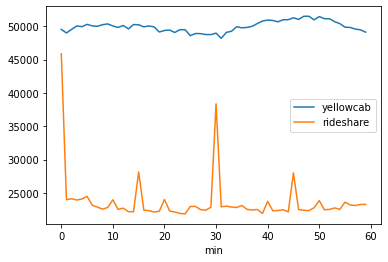

In [32]:
nyc_df.groupby('min').agg({'yellowcab':'sum','rideshare':'sum'}).plot()

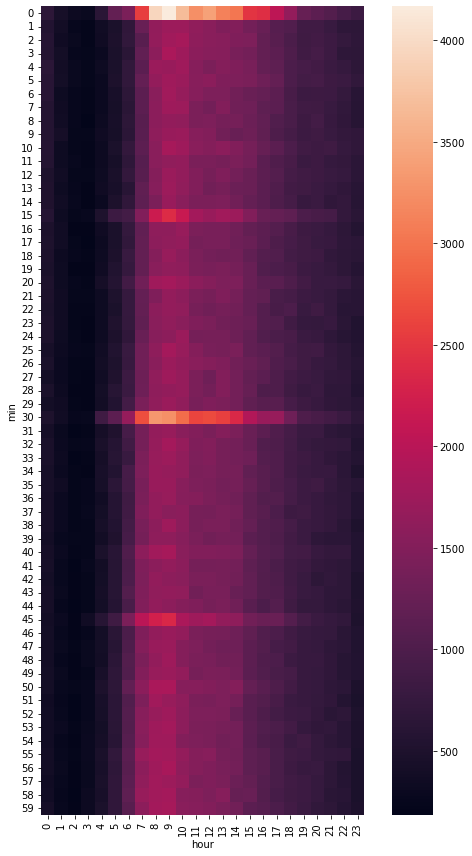

In [33]:
rideshare_pivot = pd.pivot_table(
    nyc_df,
    index='min',
    columns='hour',
    values='rideshare',
    aggfunc='sum'
)

f,ax = plt.subplots(figsize=(8,12))

sb.heatmap(
    rideshare_pivot,
    ax=ax,
    square=True
)

f.tight_layout()

### Daily patterns: Circadian rhythms

Most people in a given location sleep around the same time. When people are asleep, nothing much happens and this should be apparent in the data.

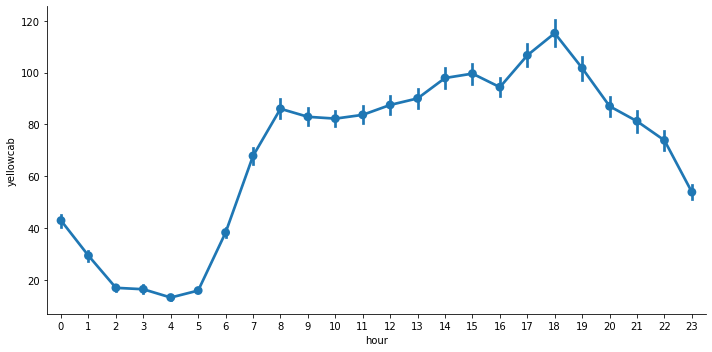

In [34]:
sb.catplot(
    x='hour',
    y='yellowcab',
    data=nyc_df,
    kind='point',
    aspect = 2
)

### Weekly patterns: Workdays and weekends

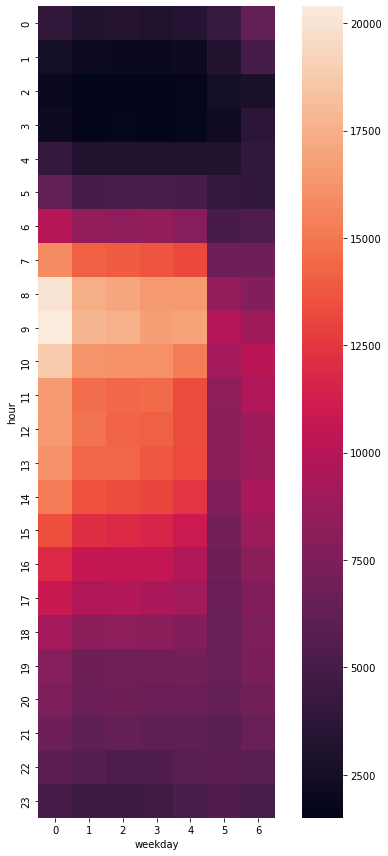

In [35]:
rideshare_pivot = pd.pivot_table(
    nyc_df,
    index='hour',
    columns='weekday',
    values='rideshare',
    aggfunc='sum'
)

f,ax = plt.subplots(figsize=(8,12))

sb.heatmap(
    rideshare_pivot,
    ax=ax,
    square=True
)

f.tight_layout()

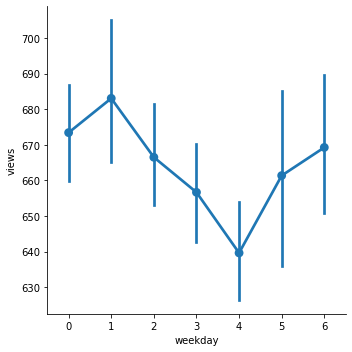

In [36]:
sb.catplot(x='weekday',y='views',data=pageviews_df,kind='point')

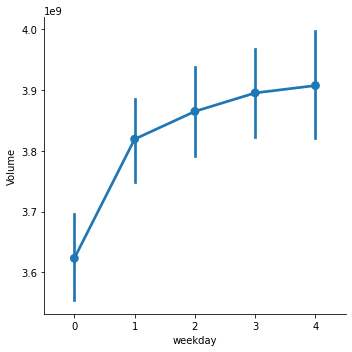

In [37]:
sb.catplot(x='weekday',y='Volume',data=sp500_df,kind='point')

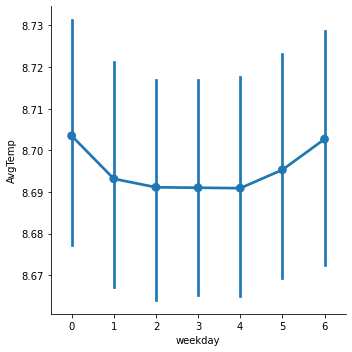

In [38]:
sb.catplot(x='weekday',y='AvgTemp',data=temp_df,kind='point')

### Monthly patterns: Sometimes, but not in our data

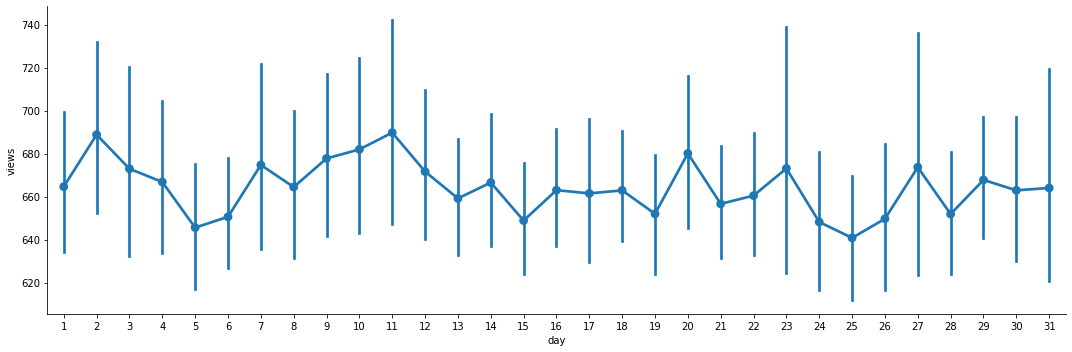

In [27]:
sb.catplot(x='day',y='views',data=pageviews_df,kind='point',aspect=3)

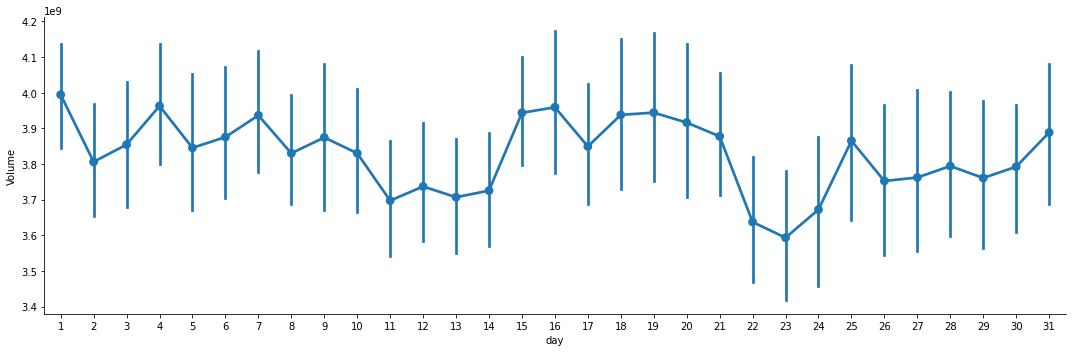

In [39]:
sb.catplot(x='day',y='Volume',data=sp500_df,kind='point',aspect=3)

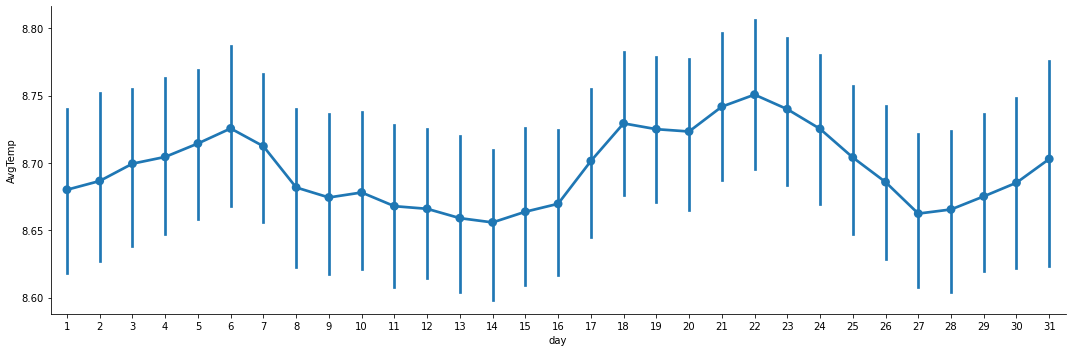

In [40]:
sb.catplot(x='day',y='AvgTemp',data=temp_df,kind='point',aspect=3)

### Annual patterns: Seasonality

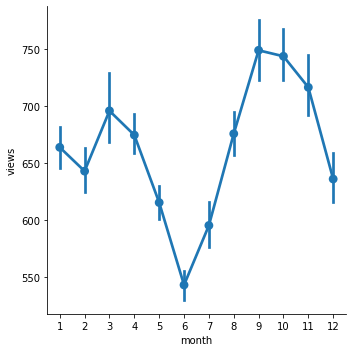

In [41]:
sb.catplot(x='month',y='views',data=pageviews_df,kind='point',nboot=10000)

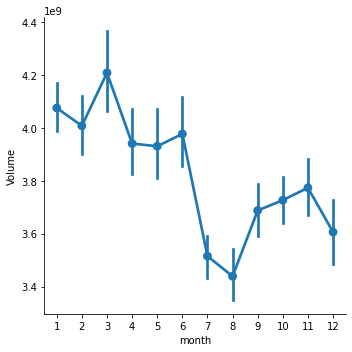

In [42]:
sb.catplot(x='month',y='Volume',data=sp500_df,kind='point')

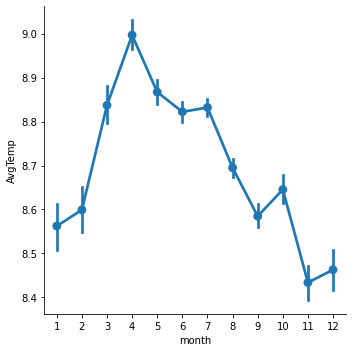

In [43]:
sb.catplot(x='month',y='AvgTemp',data=temp_df,kind='point')

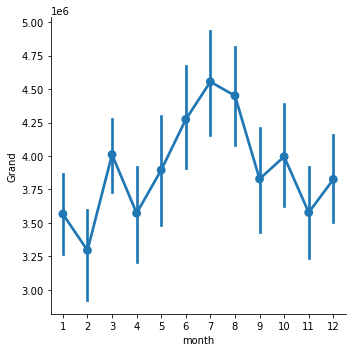

In [44]:
sb.catplot(x='month',y='Grand',data=passengers_df,kind='point')

## Decomposing time series

In [49]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

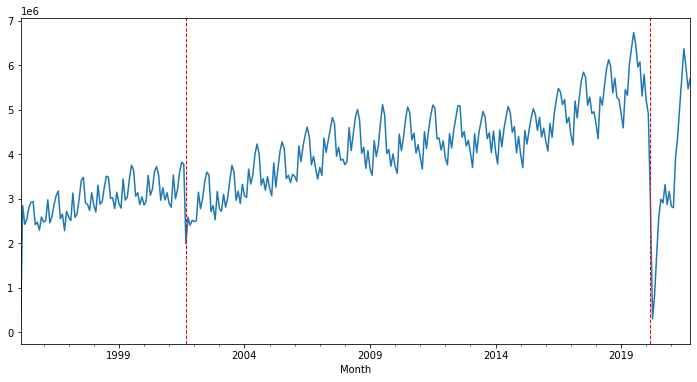

In [50]:
f,ax = plt.subplots(figsize=(12,6))

passengers_df['Grand'].plot(ax=ax)

ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)
ax.axvline(pd.Timestamp('2020-03-11'),color='r',ls='--',lw=1)

There is a strong annual pattern (at least, more on other signals hiding in the data below) in this data. If we wanted to erase this annual signal, we could use `.rolling(12).mean()` average the values across 12 months out together.

Text(0, 0.5, 'Total passengers')

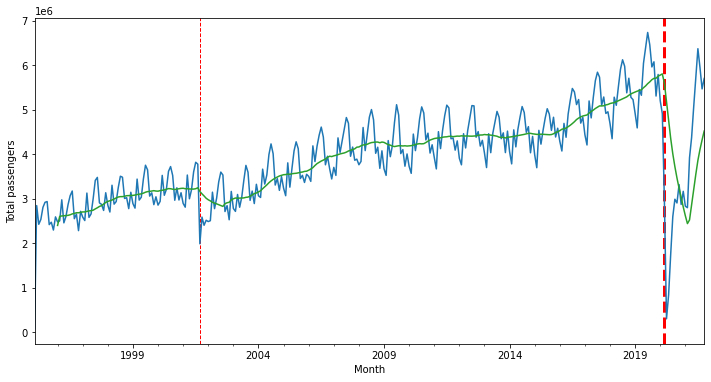

In [51]:
f,ax = plt.subplots(figsize=(12,6))

passengers_df['Grand'].plot(ax=ax)
passengers_df['Grand'].rolling(12).mean().plot(ax=ax,c='tab:green')

ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1,zorder=0)
ax.axvline(pd.Timestamp('2020-03-11'),color='r',ls='--',lw=3,zorder=0)

ax.set_ylabel('Total passengers')

### Linear model

In [52]:
passengers_df['months_since_opening'] = (passengers_df.index - pd.Timestamp('1995-01-01'))/pd.Timedelta(30,'D')
passengers_df.head()

,American,Cargo,Delta,Frontier,Other,Southwest,United,United Express,Grand,month,months_since_opening,Grand_smoothed
Month,,,,,,,,,,,,
1995-02-01,5833,0,4805,1434,8625,NaN,47230,2635,70562,2,1.033333,NaN
1995-03-01,228196,0,200964,36703,245171,NaN,1962445,169190,2842669,3,1.966667,NaN
1995-04-01,184229,0,157853,40050,191393,NaN,1724836,124351,2422712,4,3.000000,NaN
1995-05-01,187990,0,162622,41403,171425,NaN,1833305,135800,2532545,5,4.000000,NaN
1995-06-01,229348,0,198499,43754,186030,NaN,1975754,170033,2803418,6,5.033333,NaN


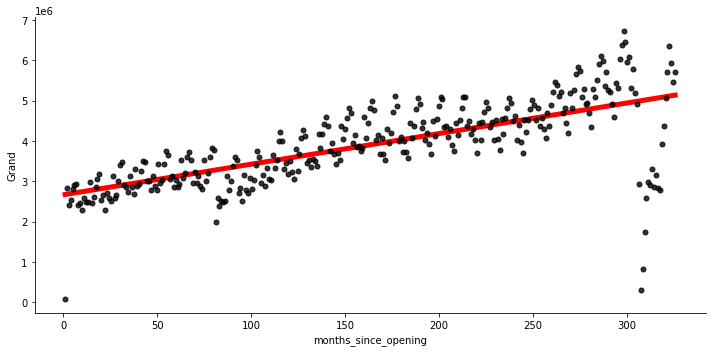

In [53]:
g = sb.lmplot(
    x='months_since_opening',
    y='Grand',
    data=passengers_df,
    aspect=2,
    ci=0,
    scatter_kws={'color':'k','s':25},
    line_kws={'lw':5,'color':'r','zorder':0}
)

### De-periodized data

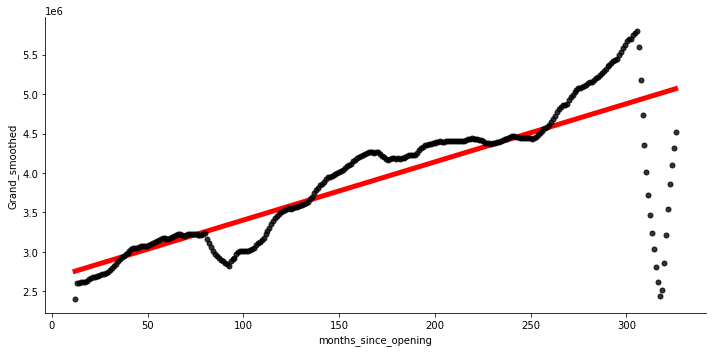

In [54]:
passengers_df['Grand_smoothed'] = passengers_df['Grand'].rolling(12).mean()

g = sb.lmplot(
    x='months_since_opening',
    y='Grand_smoothed',
    data=passengers_df,
    aspect=2,
    ci=0,
    scatter_kws={'color':'k','s':25},
    line_kws={'lw':5,'color':'r','zorder':0}
)

### Additive models

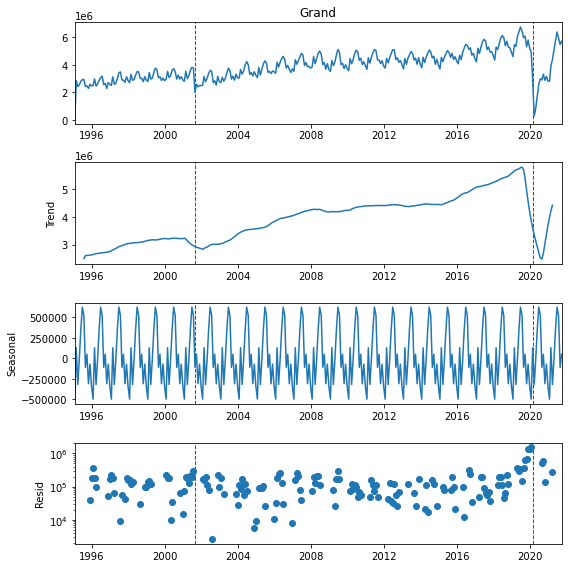

In [56]:
decomposition = sm.tsa.seasonal_decompose(passengers_df['Grand'],model='additive')

plt.rcParams["figure.figsize"] = (8,8)
f = decomposition.plot()

for _ax in f.axes:
    _ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1,zorder=0)
    _ax.axvline(pd.Timestamp('2020-03-11'),color='r',ls='--',lw=1,zorder=0)
    
f.axes[-1].set_yscale('log')

### Autocorrelation

Text(0, 0.5, 'Passenger volume in month t+1')

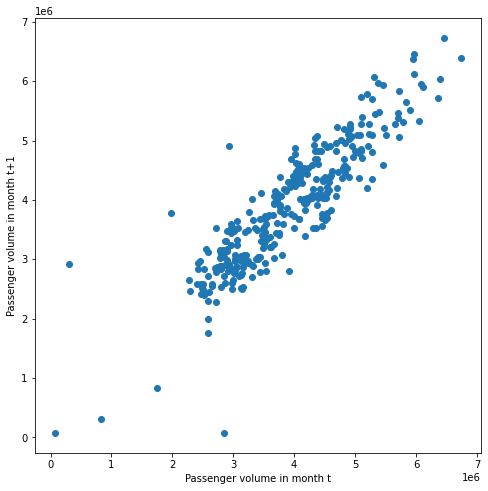

In [57]:
f,ax = plt.subplots(figsize=(8,8))

x = passengers_df['Grand']
y = passengers_df['Grand'].shift(1).fillna(method='bfill')

ax.scatter(x,y)
ax.set_xlabel('Passenger volume in month t')
ax.set_ylabel('Passenger volume in month t+1')

In [58]:
np.corrcoef(passengers_df['Grand'],passengers_df['Grand'].shift(1).fillna(method='bfill'))[0,1]

0.89460771408251

In [59]:
np.corrcoef(passengers_df['Grand'],passengers_df['Grand'].shift(2).fillna(method='bfill'))[0,1]

0.8162779695804339

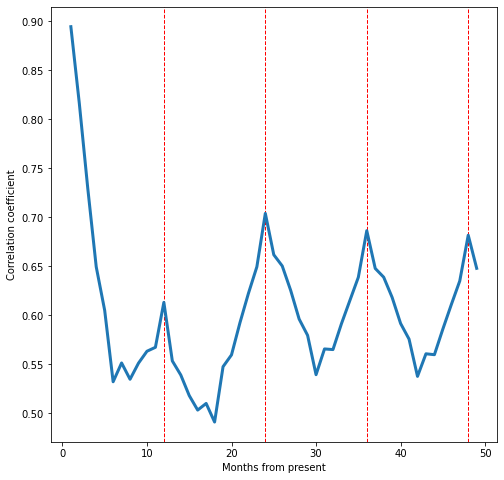

In [60]:
corr_shift_d = {}

for _shift in range (1,50):
    corr_shift_d[_shift] = np.corrcoef(passengers_df['Grand'],passengers_df['Grand'].shift(_shift).fillna(method='bfill'))[0,1]

ax = pd.Series(corr_shift_d).plot(lw=3)
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('Months from present')

for t in [12,24,36,48]:
    ax.axvline(t,c='r',zorder=0,lw=1,ls='--')

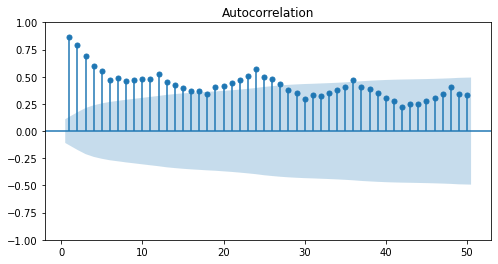

In [45]:
f,ax = plt.subplots(figsize=(8,4))

fig1 = sm.graphics.tsa.plot_acf(passengers_df['Grand'],zero=False,lags=50,ax=ax,alpha=.05)

## Forecasting

[Prophet](https://facebook.github.io/prophet/) is a time series forecasting tool developed (and obviously used by) data scientists at Facebook. There are a variety of more advanced statistical methods for modelling time series ([ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), SARIMA, *etc*.) but these often involve doing computation-intensive [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization) to find appropriate parameters or having deep understanding of the data or a theory to translate into parameters. Forecasting methods like ARMA, ARIMA, *etc*. are outside the scope of the class.

The reason we're looking at Prophet is because it does all of these (and more!), *mostly* automatically. Definitely check out the [documentation](https://facebook.github.io/prophet/) and examples in both R and Python.

I've adapted the [Getting Started](https://facebook.github.io/prophet/docs/quick_start.html#python-api) documentation for our purposes here. Prophet wants a simple DataFrame containing only a column "ds" with timestamps and a column "y" with values for that date.

**AT THE TERMINAL WINDOW**, run this command and agree to update when it requests:

`conda install -c conda-forge prophet`

In [61]:
# Import the Prophet model object
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


### Forecasting airline passenger traffic
Prophet wants a simple DataFrame with two columns labeled specifically: "ds" contains the timestamps and "y" contains the values.

In [63]:
passengers_df['Grand']

Month
1995-02-01      70562
1995-03-01    2842669
1995-04-01    2422712
1995-05-01    2532545
1995-06-01    2803418
               ...   
2021-06-01    5715347
2021-07-01    6368149
2021-08-01    5942674
2021-09-01    5464881
2021-10-01    5699357
Name: Grand, Length: 321, dtype: int64

In [62]:
# Pull out one column and copy from the parent DataFrame so we can change it
passengers_prophet_df = passengers_df['Grand'].copy()

# Reset index to get the timestamps in index into a column
passengers_prophet_df = passengers_prophet_df.reset_index()

# Rename the columns to ds and y
passengers_prophet_df.columns = ['ds','y']

# Inspect
passengers_prophet_df.head()

,ds,y
0,1995-02-01,70562
1,1995-03-01,2842669
2,1995-04-01,2422712
3,1995-05-01,2532545
4,1995-06-01,2803418


In [71]:
# Make an empty passenger_model
passenger_model = Prophet(changepoints=[pd.Timestamp('2001-09-01'),pd.Timestamp('2020-03-01')])

# Fit the empty model with the observed data
passenger_model.fit(passengers_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -10.5809
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       594.835    0.00430528       78.3758    3.54e-05       0.001       58  LS failed, Hessian reset 
      26       595.355    0.00115305       23.0501   3.607e-05       0.001       98  LS failed, Hessian reset 
      42       595.502   7.50503e-05       15.0356   8.703e-10       0.001      194  LS failed, Hessian reset 
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -370.668
Iteration  1. Log joint probability =    258.433. Improved by 629.101.
Iteration  2. Log joint probability =    468.405. Improved by 209.972.
Iteration  3. Log joint probability =    582.716. Improved by 114.311.
Iteration  4. Log joint probability =    593.417. Improved by 10.7016.
Iteration  5. Log joint probability =    594.471. Improved by 1.05327.
Iteration  6. Log joint probability =     594.53. Improved by 0.0593855.
Iteration  7. Log joint probability =    594.625. Improved by 0.0947431.
Iteration  8. Log joint probability =    595.601. Improved by 0.975794.
Iteration  9. Log joint probability =    595.609. Improved by 0.00814366.
Iteration 10. Log joint probability =    595.609. Improved by 0.000295259.
Iteration 11. Log joint probability =    595.609. Improved by 0.0002116.
Iteration 12. Log joint probability =     595.61. Improved by 0.000917414.
Iteration 13. Log joint probability =     595.61. Improved by 0.00012652.
Iteration 14. 

Make a DataFrame extending into the future.

In [72]:
passengers_future_df

,ds
0,1995-02-01
1,1995-03-01
2,1995-04-01
3,1995-05-01
4,1995-06-01
...,...
436,2031-05-31
437,2031-06-30
438,2031-07-31
439,2031-08-31


In [73]:
# Make a DataDrame going a decade into the future
passengers_future_df = passenger_model.make_future_dataframe(periods=120,freq='M')

# Use the parameters the model learned to forecast into the future
passengers_forecast_df = passenger_model.predict(passengers_future_df)

/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Inspect the forecast compared to the observed data.

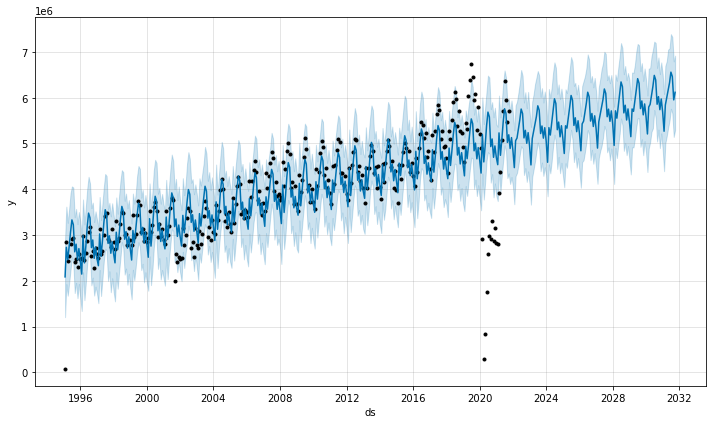

In [74]:
f_forecast = passenger_model.plot(passengers_forecast_df)

Visualize the components.

/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


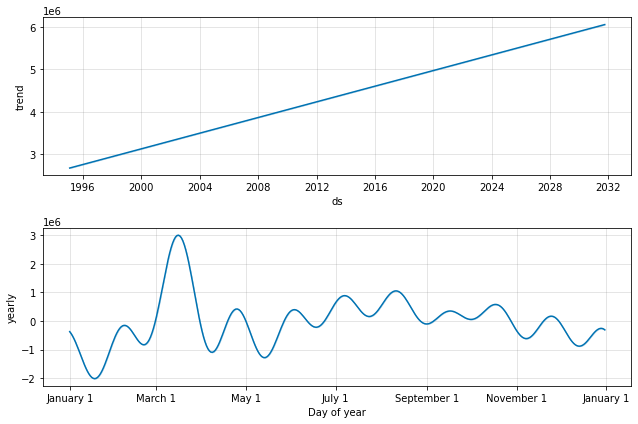

In [75]:
f_components = passenger_model.plot_components(passengers_forecast_df)

Visualizing residuals.

Text(0.5, 1.0, 'Error between observations and Prophet model predictions')

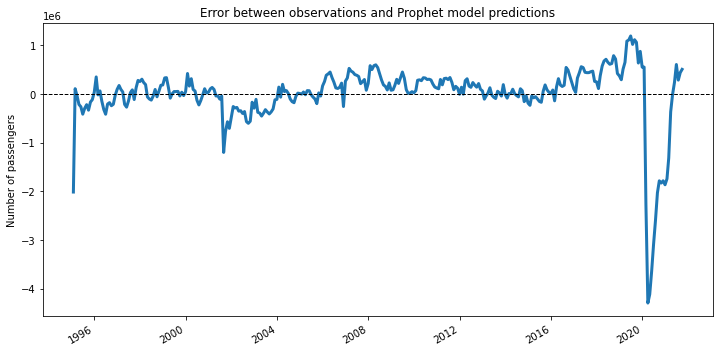

In [76]:
# Calculate the difference between the observed passengers and model predictions
residuals = passengers_prophet_df['y'] - passengers_forecast_df['yhat']

# Use the Timestamps from the future DataFrame as an index
residuals.index = passengers_forecast_df['ds']

# Start the plot
f,ax = plt.subplots(figsize=(12,6))

# Make the plot
residuals.plot(ax=ax,lw=3)

# Add line at 0
ax.axhline(0,c='k',lw=1,ls='--')

# Label axes
ax.set_xlabel(None)
ax.set_ylabel('Number of passengers')
ax.set_title('Error between observations and Prophet model predictions')

### Forecasting pageviews

In [77]:
# Pull out one column and copy from the parent DataFrame so we can change it
pageviews_prophet_df = pageviews_df['views'].copy()

# Reset index to get the timestamps in index into a column
pageviews_prophet_df = pageviews_prophet_df.reset_index()

# Rename the columns to ds and y
pageviews_prophet_df.columns = ['ds','y']

# Inspect
pageviews_prophet_df.head()

,ds,y
0,2015-07-01,563
1,2015-07-02,486
2,2015-07-03,424
3,2015-07-04,388
4,2015-07-05,407


In [78]:
# Make an empty passenger_model
pageviews_model = Prophet()

# Fit the empty model with the observed data
pageviews_model.fit(pageviews_prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -6.14918


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6393.21    0.00181413       260.029           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6400.08   0.000319523       202.153      0.7851      0.7851      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6402.03    0.00588424       284.454      0.1626           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6403.68   0.000769327       205.732      0.4102           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       6404.19   7.65158e-05       136.548    2.83e-07       0.001      560  LS failed, Hessian reset 
     465       6404.57   6.50848e-05       126.637   8.448e-07       0.001      6

In [79]:
# Make a DataDrame going a decade into the future
pageviews_future_df = pageviews_model.make_future_dataframe(periods=365*5,freq='D')

# Use the parameters the model learned to forecast into the future
pageviews_forecast_df = pageviews_model.predict(pageviews_future_df)

/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


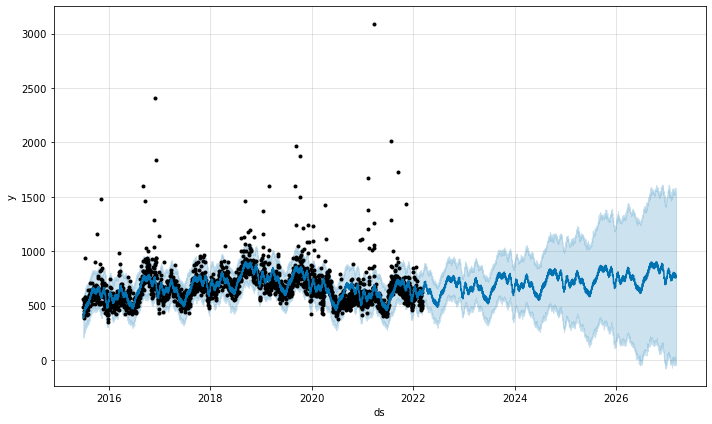

In [80]:
f_forecast = pageviews_model.plot(pageviews_forecast_df)

/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/briankeegan/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


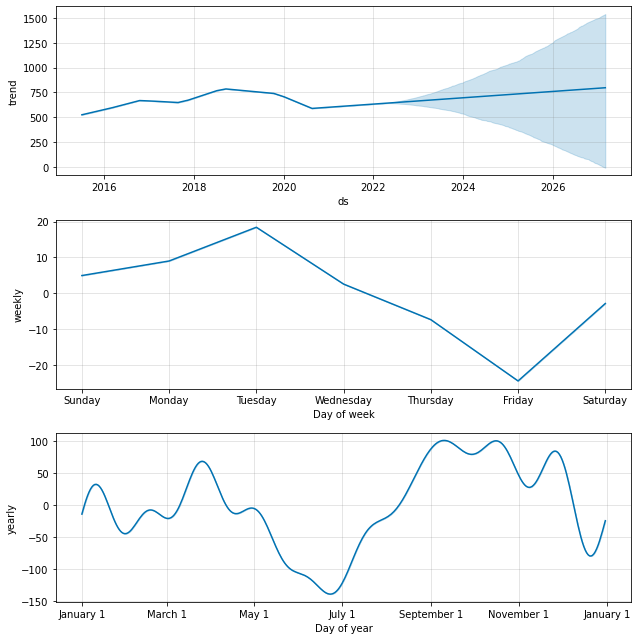

In [83]:
f_components = pageviews_model.plot_components(pageviews_forecast_df)

Text(0.5, 1.0, 'Error between observations and Prophet model predictions')

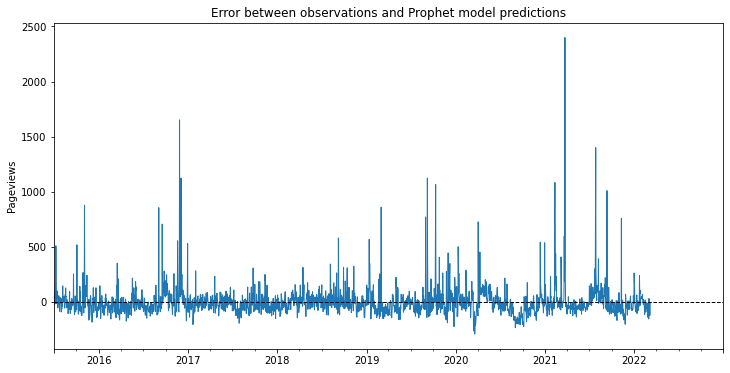

In [84]:
# Calculate the difference between the observed passengers and model predictions
residuals = pageviews_prophet_df['y'] - pageviews_forecast_df['yhat']

# Use the Timestamps from the future DataFrame as an index
residuals.index = pageviews_forecast_df['ds']

# Start the plot
f,ax = plt.subplots(figsize=(12,6))

# Make the plot
residuals.loc[:'2022'].plot(ax=ax,lw=1)

# Add line at 0
ax.axhline(0,c='k',lw=1,ls='--')

# Label axes
ax.set_xlabel(None)
ax.set_ylabel('Pageviews')
ax.set_title('Error between observations and Prophet model predictions')

How are the residuals distributed?

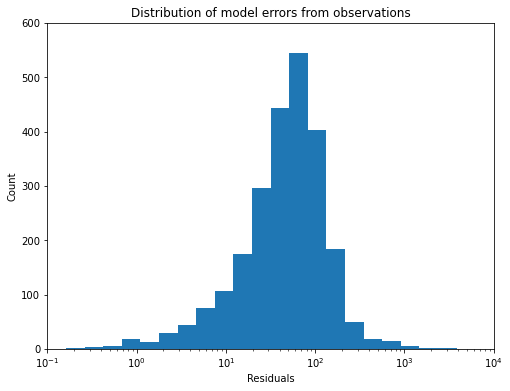

In [85]:
f,ax = plt.subplots(figsize=(8,6))

residuals.abs().hist(bins=np.geomspace(1e-1,1e4,25),ax=ax)
ax.set_xscale('log')
ax.set_xlim((1e-1,1e4))
ax.set_ylim((0,600))
ax.set_xlabel('Residuals')
ax.set_ylabel('Count')
ax.set_title('Distribution of model errors from observations')
ax.grid(None)

(0.0, 4000.0)

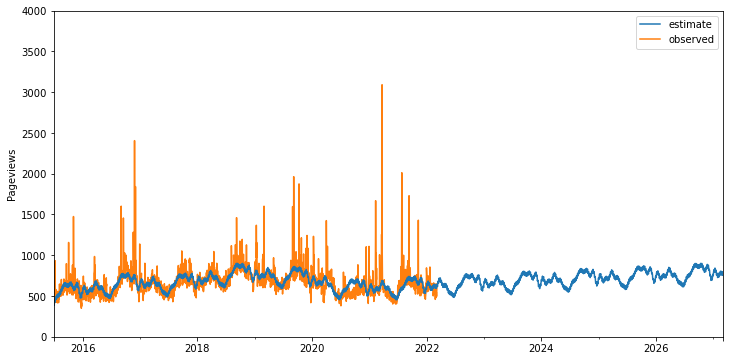

In [86]:
f,ax = plt.subplots(figsize=(12,6))

pageviews_forecast_df.plot(
    x='ds',
    y='yhat',
    ax=ax,
    label='estimate',
    color='tab:blue'
)

pageviews_prophet_df.plot(
    x='ds',
    y='y',
    ax=ax,
    zorder=0,
    label='observed',
    color='tab:orange'
)

ax.set_ylabel('Pageviews')
ax.set_xlabel(None)
ax.set_ylim((0,4000))

## Exercises

Use `sm.tsa.seasonal_decompose` from statsmodels to visualize the trend, seasonal, and residual components of `temp_df`.

Create a Prophet DataFrame with the `temp_df` that contains only a "ds" and a "y" column.

Start and fit the Prophet model using the "prophet-ized" DataFrame above.

Make the future DataFrame and use the model to make the forecast.

Plot the forecast.

Plot the residuals over time.

Visualize the distribution of the residuals.

## Appendix

### Berkeley Earth Surface Temperature

Read the "Daily Land" average temperature data from [BEST](http://berkeleyearth.org/data/).

In [24]:
# Read daily temps from source
raw_best_df = pd.read_csv(
    'http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt',
    header=None,
    sep='\s+',
    skiprows=23,
    low_memory=False
)

# Rename columns
raw_best_df.columns = ['Date Number','Year','Month','Day','Day of Year','Anomaly']

# Construct date
raw_best_df['Date'] = pd.to_datetime(raw_best_df[['Year','Month','Day']])

# Anomaly from 1951-1980 average of 8.59
raw_best_df['AvgTemp'] = raw_best_df['Anomaly'] + 8.59

# Extract the series
avg_temp_s = raw_best_df.set_index('Date')['AvgTemp']
avg_temp_s.to_csv('avg_temp_1880_2021.csv')

# Inspect
avg_temp_s.head()

Date
1880-01-01    8.056
1880-01-02    9.431
1880-01-03    8.956
1880-01-04    9.870
1880-01-05    9.213
Name: AvgTemp, dtype: float64

### NYC cab rides

New York City's Taxi and Limousine Commission publishes [high-resolution anonymized data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) about the pick-up and drop-off location for every trip (including licensed rideshare services) starting or ending in the city's boundaries.

In [36]:
yellow_raw_df = pd.read_csv(
    'yellow_tripdata_2020-03.csv',
    parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime']
)

fhv_raw_df = pd.read_csv(
    'fhv_tripdata_2020-03.csv',
    parse_dates=['pickup_datetime','dropoff_datetime']
)

nyc_pickups_df = pd.DataFrame({
    'yellowcab':yellow_raw_df.groupby(pd.Grouper(key='tpep_pickup_datetime',freq='min')).apply(len),
    'rideshare':fhv_raw_df.groupby(pd.Grouper(key='pickup_datetime',freq='min')).apply(len)
})

/var/folders/lr/v195xr617d32k2zdwwh30sb40000gn/T/ipykernel_35624/2034204351.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  yellow_raw_df = pd.read_csv('yellow_tripdata_2020-03.csv',parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime'])


In [39]:
nyc_pickups_clean_df = nyc_pickups_df.loc[pd.date_range('2020-03-01','2020-03-31',freq='min')]
nyc_pickups_clean_df.index.name = 'timestamp'

nyc_pickups_clean_df.to_csv('nyc_pickups.csv')

### Wikipedia pageview data
Get the pageviews for the University of Colorado Boulder's [Wikipedia article](https://en.wikipedia.org/wiki/University_of_Colorado_Boulder).

In [70]:
from wikifunctions import get_pageviews

In [71]:
ucb_pvs = get_pageviews('University of Colorado Boulder')
ucb_pvs.to_csv('pageviews_ucb.csv')